# Report Practical Session 2 MARY Loïc

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import pandas as pd

# Table of contents

* [1.Dataset visualization and pre-processing](#chapter1)
* [2. Least Squares Regression](#chapter2)
    * [2.1 Parameters by solving the linear problem](#section_2_1)
        * [2.1.1 Prediction & Performance on the Training data](#section_2_1_1)
        * [2.1.2 Prediction & Performance on the Test data](#section_2_1_2)
    * [2.2 Least Squares Regression with Scikit Learn](#section_2_2)

* [3. Ridge Regression](#chapter3)
    * [3.1 Ridge with default parameters](#section_3_1)
    * [3.2 Selection of $\lambda$](#section_3_2)
        * [3.2.1 Evolution of MSE  depending on $\lambda$](#section_3_2_1)
        * [3.2.2 Model with the best $\lambda$](#section_3_2_2)
        
* [4. Lasso Regression](#chapter4)
    * [4.1 Lasso with default parameters](#section_4_1)
    * [4.2 Selection of $\lambda$](#section_4_2)
        * [4.2.1 Evolution of MSE  depending on $\lambda$](#section_4_2_1)
        * [4.2.2 Model with the best $\lambda$](#section_4_2_2)

* [5. Review on linear models](#chapter5)

* [6. Non Linear Regression](#chapter6)
    * [6.1 Random Forest](#section_6_1)
        * [6.1.1 Random Forest with default parameters](#section_6_1_1)
        * [6.1.2 Best parameters](#section_6_1_2)
        * [6.1.3 Random Forest with the best parameters](#section_6_1_3)
    * [6.2 Support Vector Regression (SVR)](#section_6_2)
        * [6.2.1 SVR with default parameters](#section_6_2_1)
        * [6.2.2 Best parameters](#section_6_2_2)
        * [6.2.3 SVR with the best parameters](#section_6_2_3)
    * [6.3 Multi Layer Perceptrons (MLP)](#section_6_3)
        * [6.3.1 MLP with default parameters](#section_6_3_1)
        * [6.3.2 Best parameters](#section_6_3_2)
        * [6.3.3 MLP with the best parameters](#section_6_3_3)

* [7. Final compararison of the performances](#chapter7)    

        



# 1. Data visualization and pre-processing<a class="anchor" id="chapter1"></a>

In [36]:
data = np.load("ECoG.npz")
Xall = data['Xall']
Yall = data['Yall']

Fe = data['Fe']

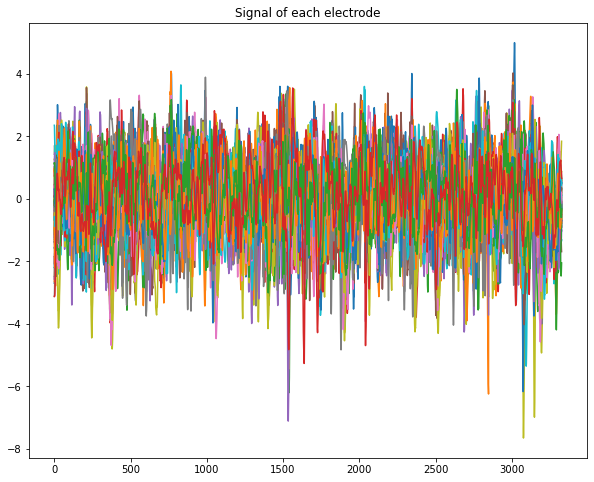

In [37]:
plt.figure(figsize=(10,8))
for i in range(Xall.shape[1]):
    plt.plot(Xall[:,i])

plt.title("Signal of each electrode")
plt.show()

Above is the graph representing the time signal of each electrode . The values are in the interval [-7 $\mu$V ; 5 $\mu$V]

Now, I plot the signal of electrode 48 depending on the signal of electrode 45. And I color the points according to their value of Y(the flexion of the thumb)

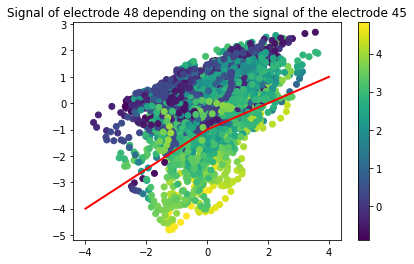

In [38]:
plt.scatter(Xall[:,45],Xall[:,48],c=Yall)
plt.plot([-4,0,4],[-4,-1,1],c="red",linewidth=2)
plt.title("Signal of electrode 48 depending on the signal of the electrode 45")
plt.colorbar()

We remark that if the signals of the 2 electrodes are under the red line, Y is between 3 and 4 whereas when the signals are over the redline , they are between 1 and 0. So, those electrodes should be important because their signals can give the predicition. It is like those signals can cluster the predictions depending on the values of the signals.

I split the original dataset in a training and a testing dataset. Because the data depends on time, we may not shuffle the data because the predictions are based on the signal in the past.

In [39]:
n = 1000
Xall_train = Xall[:n,:]
Xall_test = Xall[n:,:]
Yall_train = Yall[:n,]
Yall_test = Yall[n:,]

# 2. Least Squares Regression<a class="anchor" id="chapter2"></a>

# 2.1 Parameters by solving the linear problem<a class="anchor" id="section_2_1"></a>

We want to find W and b such that those variables minimize $\frac{1}{n}\sum_{i=1}^{n}(Y_i - W^TX_i - b)^2$

In [40]:
X_train_tilde = np.concatenate((Xall_train,np.ones((n,1))),axis=1)

In [41]:
def estimator_parameters(X,y):
    d = X.shape[1]
    A = np.dot(X.T,X)
    A_inv = np.linalg.inv(A)
    B = np.dot(A_inv,X.T)
    theta_hat = np.dot(B,y)
    return theta_hat[:d-1,:],theta_hat[-1]

In [42]:
w,b = estimator_parameters(X_train_tilde,Yall_train)

In [43]:
def prediction(X,w,b):
    y_hat = []
    n = X.shape[0]
    for i in range(n):
        pred = np.dot(X[i].T,w) + b
        y_hat.append(pred)
    return y_hat

In [44]:
prediction_train = prediction(Xall_train,w,b)
prediction_test = prediction(Xall_test,w,b)

# 2.1.1 Prediction & Performance for the Training data<a class="anchor" id="section_2_1_1"></a>

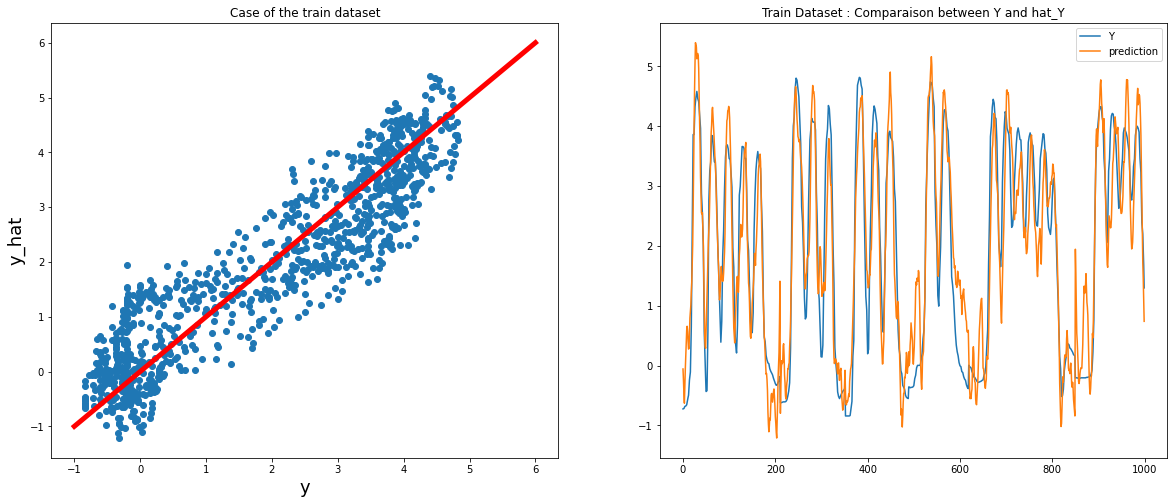

In [45]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(Yall_train,prediction_train,"o")
plt.xlabel("y",fontsize=18)
plt.ylabel("y_hat",fontsize=18)
plt.plot([-1,6],[-1,6],c="red",linewidth=5)
plt.title("Case of the train dataset")

plt.subplot(1,2,2)
plt.plot(Yall_train ,label="Y")
plt.plot(prediction_train , label="prediction")
plt.legend()
plt.title("Train Dataset : Comparaison between Y and hat_Y")

plt.show()



In [46]:
mse_train = round(mean_squared_error(Yall_train,prediction_train),2)
r2_score_train = round(r2_score(Yall_train,prediction_train),2)

print(f"The MSE for the training dataset is : {mse_train}")
print(f"The R2 coefficient for the training dataset is : {r2_score_train}")

The MSE for the training dataset is : 0.5
The R2 coefficient for the training dataset is : 0.84


# 2.1.2 Prediction & Performance for the Test dataset<a class="anchor" id="section_2_1_2"></a>

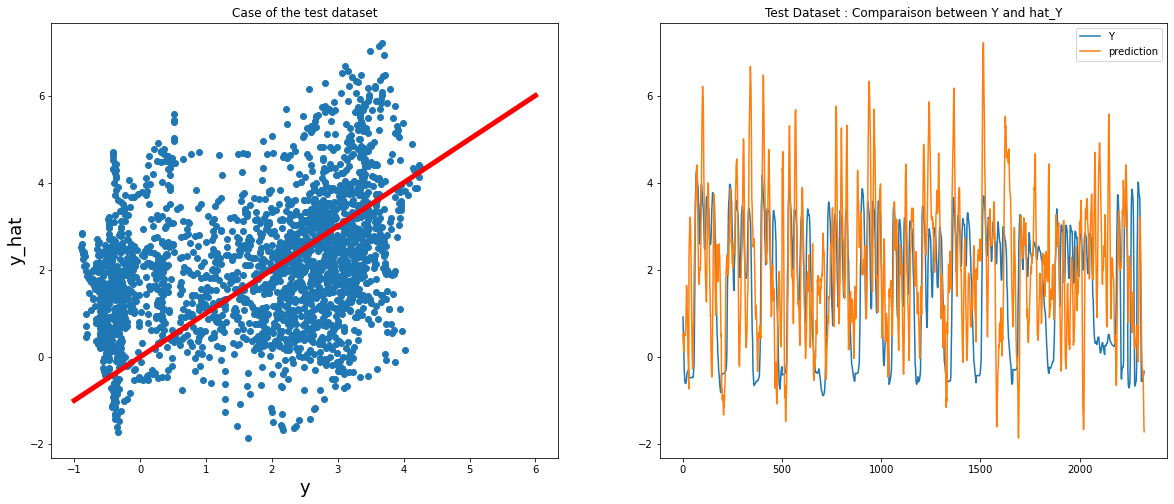

In [47]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(Yall_test,prediction_test,"o")
plt.xlabel("y",fontsize=18)
plt.ylabel("y_hat",fontsize=18)
plt.plot([-1,6],[-1,6],c="red",linewidth=5)


plt.title("Case of the test dataset")

plt.subplot(1,2,2)
plt.plot(Yall_test ,label="Y")
plt.plot(prediction_test , label="prediction")
plt.legend()
plt.title("Test Dataset : Comparaison between Y and hat_Y")

plt.show()


For the graph at the left :
- what is under the red line is underestimated : $\hat{Y} \leq Y$ 
- what is above is overestimated : $\hat{Y} \geq Y$ 
<br/>
So to have a model with a great performance , the data of this graph should be very close to the first bissectrice (red line).
<br/>
<br/>
We can see with the graph at the right, that most of the time the predictions overestimate the flexion
<br/>
<br/>
An other important thing is that to really evaluate the performance of a model, we should only focus on metrics on the test dataset. We cannot  base the performance of the model on the train dataset !

In [48]:
mse_test = round(mean_squared_error(Yall_test,prediction_test),2)
r2_score_test = round(r2_score(Yall_test,prediction_test),2)

print(f"The MSE for the testing dataset is : {mse_test}")
print(f"The R2 coefficient for the testing dataset is : {r2_score_test}")

The MSE for the testing dataset is : 3.05
The R2 coefficient for the testing dataset is : -0.43


More the mean squared error  tends towards 0 and more the R2 coefficient  tends towards 1  on the test dataset and better is the performance of the model. R2 coefficient can be seen as MSE normalized, so those metrics are linked each other. Indeed if the MSE is good then R2 should be also (an other way to say it, if MSE is close to 0 then R2 should be close to 1 and vice versa).

Here for the linear regression, R2 is not so close to 0 and the MSE is negative. And the R2 coefficient is negative which means that the model is too bad. Normally, R2 coefficient goes from 0 to 1 , 0 is for random predictions. So, here this model predicted even worse than chance. So the linear model is bad. Let's  compare this performance with others models and try to find a better one.

# 2.1 Linear Regression with Scikit Learn<a class="anchor" id="section_2_1"></a>

I use the Least Squares Regression implement in Scikit Learn to compare it with the theorical resolution of the linear problem

In [49]:
reg = LinearRegression()
reg.fit(Xall_train,Yall_train)

LinearRegression()

Let's compare the estimated coefficients of scikit learn and those from solving the linear problem :

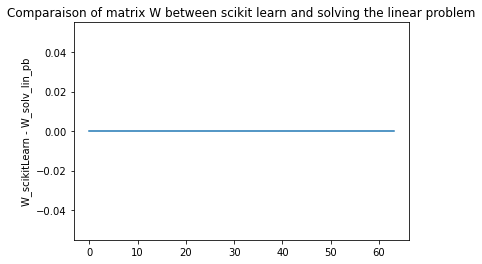

In [50]:
plt.plot([0 if x < 0.0001 else x for x in (reg.coef_ - w.T)[0]])
plt.ylabel("W_scikitLearn - W_solv_lin_pb")
plt.title("Comparaison of matrix W between scikit learn and solving the linear problem")
plt.show()

In [51]:
print(f"The bias from scikit learn method is {reg.intercept_} ")
print(f"The bias from solving the linear method is {b} ")

The bias from scikit learn method is [1.90081255] 
The bias from solving the linear method is [1.90081255] 


As expected, the coefficients estimated by the two methods are the same.

In [52]:
hat_Y_LSE = reg.predict(Xall_test)
print(f"MSE : {round(mean_squared_error(Yall_test,hat_Y_LSE),2)}")
print(f"R2 : {round(r2_score(Yall_test,hat_Y_LSE),2)}")

MSE : 3.05
R2 : -0.43


As expected, the performance of the LSE model by scikit lear is the same than what's what done before by solving the linear problem.
<br/> So the conclusions about this model are the same than what I said in the previous point.

# 3. Ridge Regression<a class="anchor" id="chapter3"></a>

We want to solve the same problem of LS but with a L2 penalization on the parameters.

# 3.1 Ridge with default parameters<a class="anchor" id="section_3_1"></a>

The default parameters for Ridge is $\lambda = 1$

In [53]:
rid = Ridge(alpha = 1.0)
rid.fit(Xall_train,Yall_train)

Ridge()

In [54]:
def plots_prediction(X_train,Y_train,X_test,Y_test,dataset,model):
    
    model.fit(X_train,Y_train)
    hat_Y = model.predict(X_test)
    
    
    
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.scatter(Y_test,hat_Y)
    plt.xlabel("y",fontsize=18)
    plt.ylabel("y_hat",fontsize=18)
    plt.plot([-1,6],[-1,6],c="red",linewidth=5)
    plt.title("Case of the " +dataset+" dataset")

    plt.subplot(1,2,2)
    plt.plot(hat_Y, label = "prediction")
    plt.plot(Y_test , label="Y")
    plt.legend()
    plt.title(dataset + " Dataset : Y and hat_Y as a function of time")

    plt.show()
    
    mse = round(mean_squared_error(Y_test,hat_Y),2)
    print("The MSE for the " + dataset+ f" dataset is : {mse}")
    
    r2_sco = round(r2_score(Y_test,hat_Y),2)
    print("The R2 coefficient for the " + dataset+ f" dataset is : {r2_sco}")
    

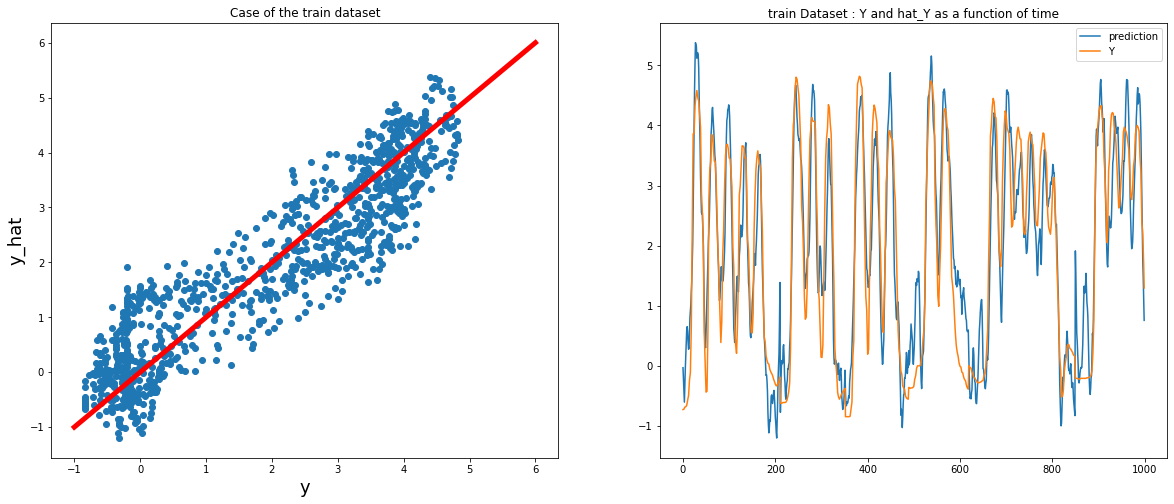

The MSE for the train dataset is : 0.5
The R2 coefficient for the train dataset is : 0.84


In [55]:
plots_prediction(Xall_train,Yall_train,Xall_train,Yall_train,'train',rid)

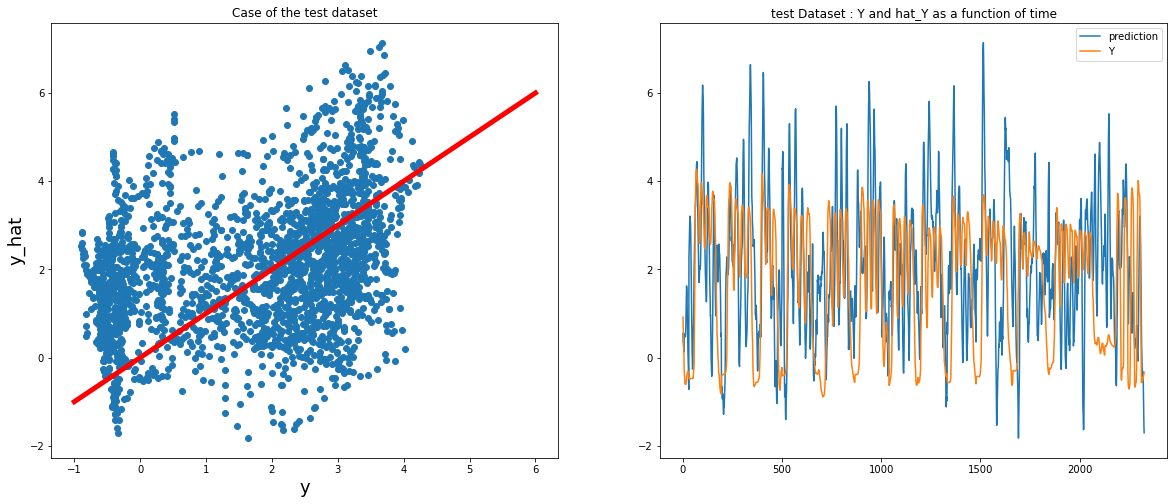

The MSE for the test dataset is : 3.0
The R2 coefficient for the test dataset is : -0.41


In [56]:
plots_prediction(Xall_train,Yall_train,Xall_test,Yall_test,'test',rid)

Regarding the performance with the MSE , Ridge regression with $\lambda$ = 1 is similar than the LS but the metrics are very closer for both models. It is not surprising because with $\lambda$ = 0 , Ridge regression is exactly LS. With $\lambda$ = 1 which is close to 0 , we have the MSE and R2 coefficient that are almost the same than the previous model.

# 3.2 Selection of $\lambda$<a class="anchor" id="section_3_1"></a>

To imporve the performance of the Ridge model, let's change the value of $\lambda$. Let's take $\lambda$ which minimizes the MSE on the test dataset. 
<br/>
So $\lambda^* = argmin_{\lambda} MSE(Ridge(\lambda))$

# 3.2.1 Evolution of MSE  depending on $\lambda$<a class="anchor" id="section_3_2_1"></a>

In [57]:
def plot_evolution_mse_lambda_ridge(X_train,Y_train,X_test,Y_test):
    #x = np.linspace(1e-3,1e5,num=100)
    x = np.logspace(-3,5,100)
    MSE_test = []
    MSE_train = []
    for alpha in x :
        rid = Ridge(alpha = alpha)
        rid.fit(X_train,Y_train)
        hat_Y_test = rid.predict(X_test)
        hat_Y_train = rid.predict(X_train)
        
        mse_test = round(mean_squared_error(Y_test,hat_Y_test),2)
        mse_train = round(mean_squared_error(Y_train,hat_Y_train),2)
        MSE_test.append(mse_test)
        MSE_train.append(mse_train)
     
    
    
    
    plt.plot(x,MSE_train,label="Train")
    plt.plot(x,MSE_test,label="Test")
    plt.title("Evolution of MSE under lambda (Ridge)")
    plt.xlabel("label")
    plt.ylabel("MSE")
    plt.xscale("log")
    plt.legend()

    plt.show() 

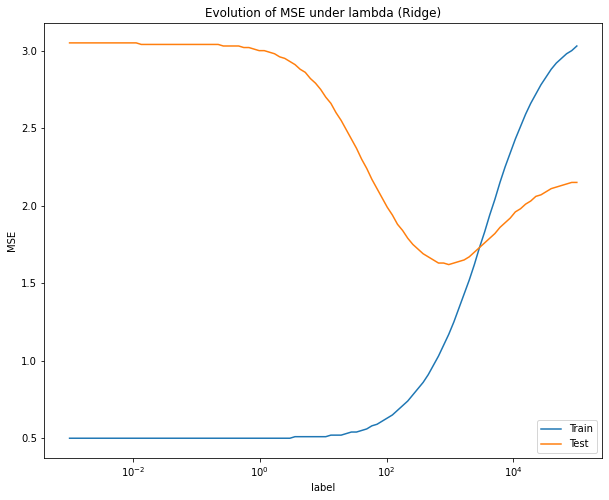

In [58]:
plt.figure(figsize=(10,8))
plot_evolution_mse_lambda_ridge(Xall_train, Yall_train, Xall_test, Yall_test)

We clearly see a minimim in $\lambda$ for the MSE on the test dataset

In [59]:
def plot_evolution_parameters_lambda_ridge(X_train,Y_train,X_test,Y_test,type_dataset):
    x = np.logspace(-3,5,100)
    
    dic_parameters = {i : [] for i in range(64)}
    
    for alpha in x :
        rid = Ridge(alpha = alpha)
        rid.fit(X_train,Y_train)
        parameters = rid.coef_.T
        
        for j in range(len(parameters)):
            dic_parameters[j].append(parameters[j])
    
    
    for k in range(len(parameters)):
        plt.semilogx(x,dic_parameters[k])
        plt.xlabel("lambda")
        plt.ylabel("Linear Parameters ")
        plt.axhline(y=0,c="red",lw=2)
        plt.title("Evolution Parameters "+type_dataset)
    
    #plt.show()

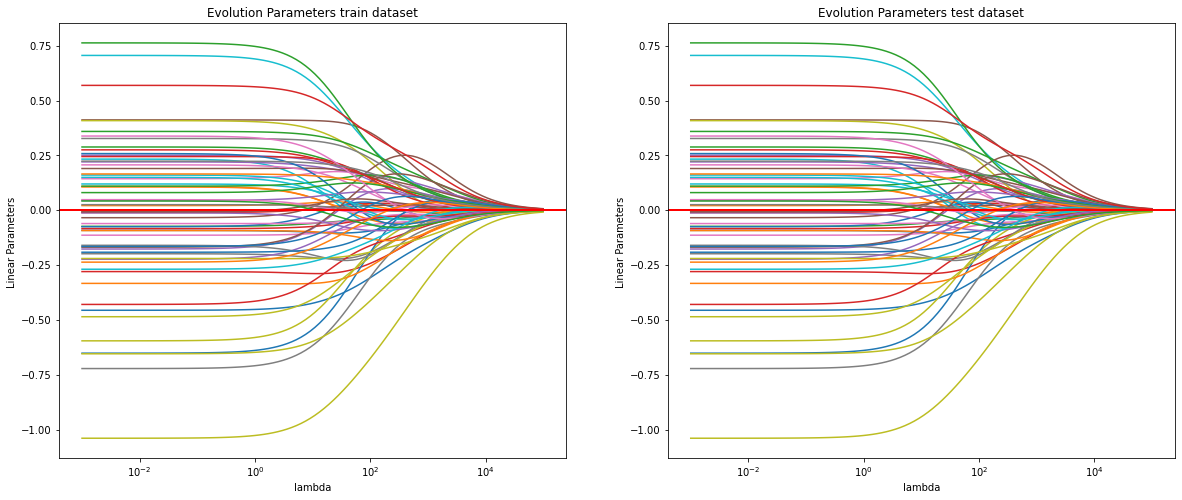

In [60]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plot_evolution_parameters_lambda_ridge(Xall_train, Yall_train, Xall_train, Yall_train, 'train dataset')

plt.subplot(1,2,2)
plot_evolution_parameters_lambda_ridge(Xall_train, Yall_train, Xall_test, Yall_test, 'test dataset')

plt.show()

When $\lambda$ increases, the more the coefficients tend towards 0.
The general tendency is to move towards 0 , but we can observe coefficients that increase and then decrease. This is due to the fact that variables are correlated so when $\lambda$ increases, some variables predominate over others.

In [61]:
def lambda_opti_ridge(X_train,Y_train,X_test,Y_test):
    x = np.logspace(-3,5,100)
    MSE = []
    for alpha in x :
        rid = Ridge(alpha = alpha)
        rid.fit(X_train,Y_train)
        hat_Y = rid.predict(X_test)
        
        mse = round(mean_squared_error(Y_test,hat_Y),2)
        MSE.append(mse)
    ind = np.argmin(MSE)
    return x[ind]

In [62]:
best_lambda_ridge = lambda_opti_ridge(Xall_train, Yall_train, Xall_test, Yall_test)
print(f"The best lambda for Ridge Regression : {best_lambda_ridge}")

The best lambda for Ridge Regression : 954.5484566618347


It is far from 0 , so it seems that this model will have a different performance than LS.

Ridge is a regularization method, so the weights of the model are under a L2 constraint. Thus, no weights can be strictly equal to 0

In [63]:
def coeff_optimated_model_ridge(X_train,Y_train,alpha):
    rid = Ridge(alpha = alpha)
    rid.fit(X_train,Y_train)
    return rid.coef_   

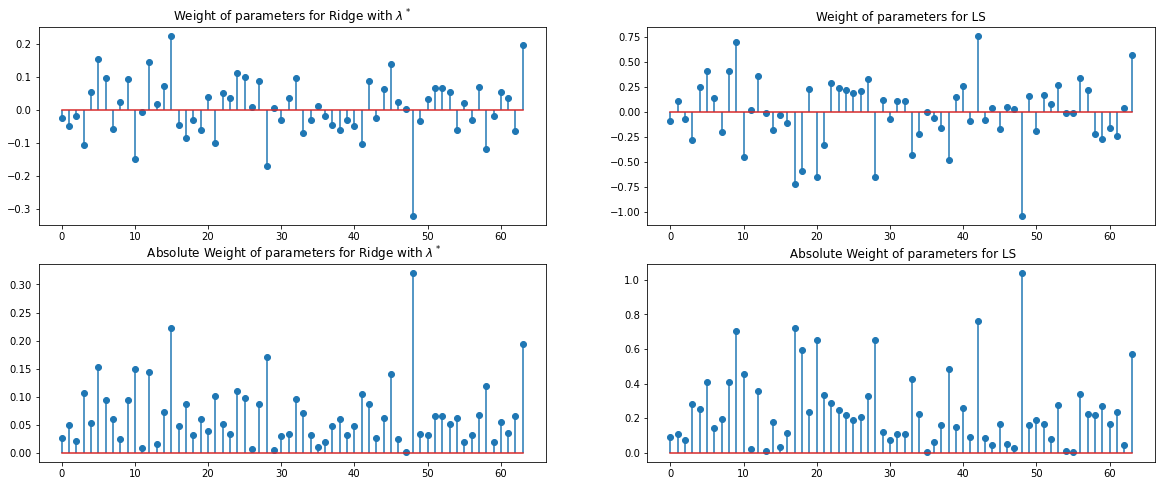

In [64]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.stem([i for i in range(64)],coeff_optimated_model_ridge(Xall_train,Yall_train,best_lambda_ridge).T,use_line_collection=True)
plt.title("Weight of parameters for Ridge with $\lambda^*$")

plt.subplot(2,2,2)
plt.stem([i for i in range(64)] , reg.coef_.T,use_line_collection=True)
plt.title("Weight of parameters for LS")

plt.subplot(2,2,3)
plt.stem([i for i in range(64)], np.abs(coeff_optimated_model_ridge(Xall_train,Yall_train,best_lambda_ridge).T),use_line_collection=True)
plt.title(" Absolute Weight of parameters for Ridge with $\lambda^*$")

plt.subplot(2,2,4)
plt.stem([i for i in range(64)] , np.abs(reg.coef_.T),use_line_collection=True)
plt.title(" Absolute Weight of parameters for LS")

plt.show()

The value of the weights can be linked to the importance of each electrode in the model. The electrodes with low absolute weight are less important than the others. If we compare the weights between the 2 models , we remark that less features have important absolute weights in the Lasso than the LS because of the penalization.

# 3.2.2 Ridge with the best $\lambda$<a class="anchor" id="section_3_2_2"></a>

In [65]:
def performance_models(Y,hat_Y):
    perf = {}
    mse = mean_squared_error(Y,hat_Y)
    r2 = r2_score(Y,hat_Y)
    perf['MSE'] = round(mse,2)
    perf["R2"] = round(r2,2)

    return perf
    

In [66]:
def optimated_model_ridge(X_train,Y_train,X,alpha):
    rid = Ridge(alpha = alpha)
    rid.fit(X_train,Y_train)

    hat_Y = rid.predict(X)
          
    return hat_Y

In [67]:
hat_Y_train_ridge = optimated_model_ridge(Xall_train, Yall_train, Xall_train, best_lambda_ridge)
hat_Y_test_ridge = optimated_model_ridge(Xall_train, Yall_train, Xall_test, best_lambda_ridge)

In [68]:
def plot_predictions_bis(Y_train,Y_test,hat_Y_test,hat_Y_train):
    
    plt.figure(figsize=(20,8))
    
    #Case for training 
    plt.subplot(2,2,1)
    
    plt.scatter(Y_train,hat_Y_train)
    plt.xlabel("y",fontsize=18)
    plt.ylabel("y_hat",fontsize=18)
    plt.plot([-1,6],[-1,6],c="red",linewidth=5)
    perf_train = performance_models(Y_train,hat_Y_train)
    
    plt.title(f"Training dataset : MSE = {perf_train['MSE']} ; R2 = {perf_train['R2']}")
    
    
    plt.subplot(2,2,2)
    
    plt.plot(hat_Y_train, label = "Prediction")
    plt.plot(Y_train, label = "Y")
    plt.title(f"Training dataset : MSE = {perf_train['MSE']} ; R2 = {perf_train['R2']}")
    plt.legend()
    
    
    plt.subplot(2,2,3)
    
    plt.scatter(Y_test,hat_Y_test)
    plt.xlabel("y",fontsize=18)
    plt.ylabel("y_hat",fontsize=18)
    plt.plot([-1,6],[-1,6],c="red",linewidth=5)
    perf_test = performance_models(Y_test,hat_Y_test)
    
    plt.title(f"Test dataset : MSE = {perf_test['MSE']} ; R2 = {perf_test['R2']}")
    
    plt.subplot(2,2,4)
    
    plt.plot(hat_Y_test, label = "Prediction")
    plt.plot(Y_test, label = "Y")
    plt.title(f"Test dataset : MSE = {perf_test['MSE']} ; R2 = {perf_test['R2']}")
    plt.legend()
    
    plt.show()
    
    
    
    
    

Here are prediction for Ridge Regression with $\lambda = \lambda^*$

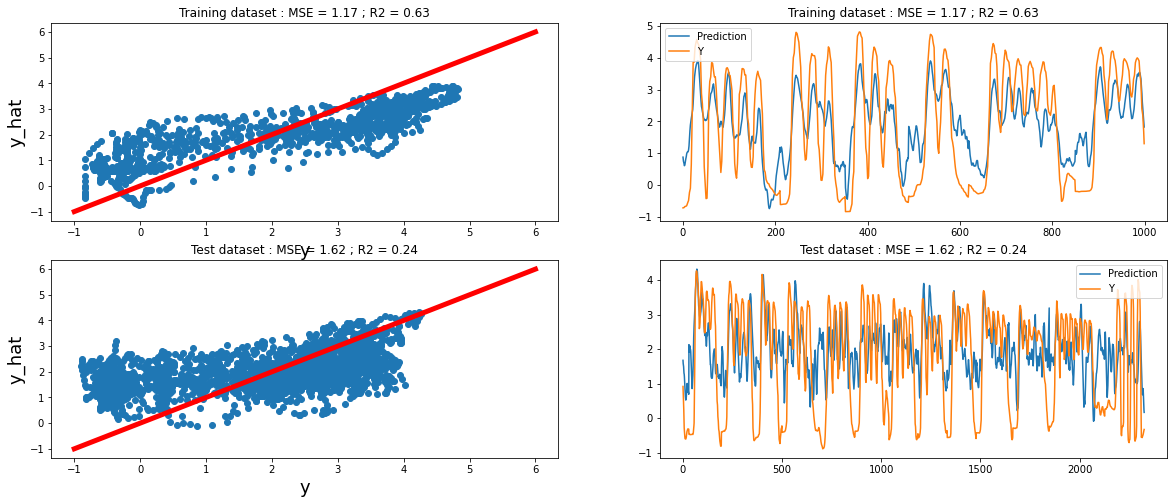

In [69]:
plot_predictions_bis(Yall_train,Yall_test,hat_Y_test_ridge,hat_Y_train_ridge)

Now, the performance of the Ridge Regression are better than the LS (for the MSE and the R2 coefficient). It is due to the constraint on the coefficients. The MSE is more closer than the LS and the R2 coefficient is positive.
<br/> What is remarkable is that this model underestimates most of the time the flexion whereas the LS model overestimates.

Let's compare those performances with an other regularization method which is Lasso Regression

# 4. Lasso Regression<a class="anchor" id="chapter4"></a>

# 4.1 Lasso with default parameters<a class="anchor" id="section_4_1"></a>

The default parameter for Lasso is $\lambda = 1$

In [70]:
lasso = Lasso()

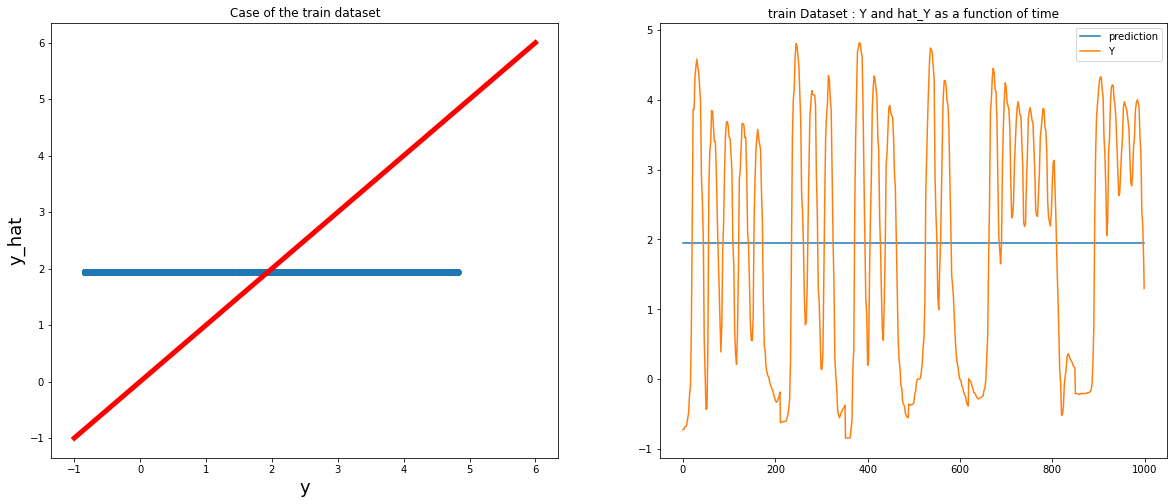

The MSE for the train dataset is : 3.14
The R2 coefficient for the train dataset is : 0.0


In [71]:
plots_prediction(Xall_train,Yall_train,Xall_train,Yall_train,'train',lasso)

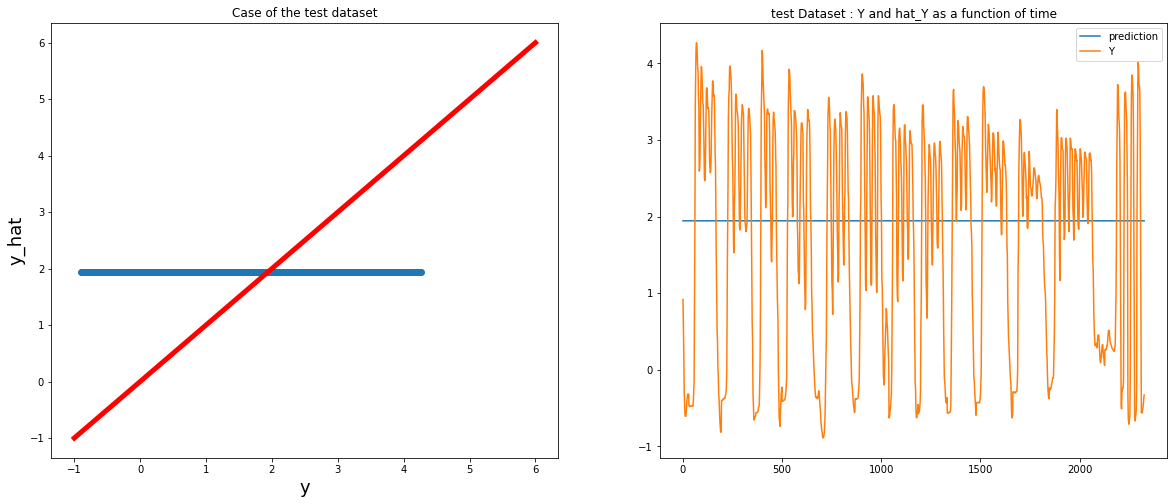

The MSE for the test dataset is : 2.19
The R2 coefficient for the test dataset is : -0.03


In [72]:
plots_prediction(Xall_train,Yall_train,Xall_test,Yall_test,'test',lasso)

We remark a surprising behaviour. All the predictions are constant to approximately 2. It probably comes from the fact that all the coefficient are equal to 0  and the predictions are equal to the bias.
<br/>
If we look at the metrics , the MSE is not closer to 0, it is better than LS but not like the Ridge. And the R2 coefficient is negative which means that the model is too bad.
<br/> Taking a Lasso regression with default parameters ($\lambda =1$) is not adapted to this dataset

# 4.2 Selection of $\lambda$<a class="anchor" id="section_4_2"></a>

Let's see the evolution of the weights of the model based on the value of $\lambda$

# 4.2.1 Evolution of MSE  depending on $\lambda$<a class="anchor" id="section_4_2_1"></a>

In [73]:
def plot_evolution_parameters_lambda_lasso(X_train,Y_train,X_test,Y_test,type_dataset):
    x = np.logspace(-3,5,100)
    
    dic_parameters = {i : [] for i in range(64)}
    
    for alpha in x :
        lasso = Lasso(alpha = alpha)
        lasso.fit(X_train,Y_train)
        parameters = lasso.coef_.T
        
        for j in range(len(parameters)):
            dic_parameters[j].append(parameters[j])
    
    
    for k in range(len(parameters)):
        plt.semilogx(x,dic_parameters[k])
        plt.xlabel("lambda")
        plt.ylabel("Linear Parameters ")
        plt.axhline(y=0,c="red",lw=2)
        plt.title("Evolution Parameters "+type_dataset)

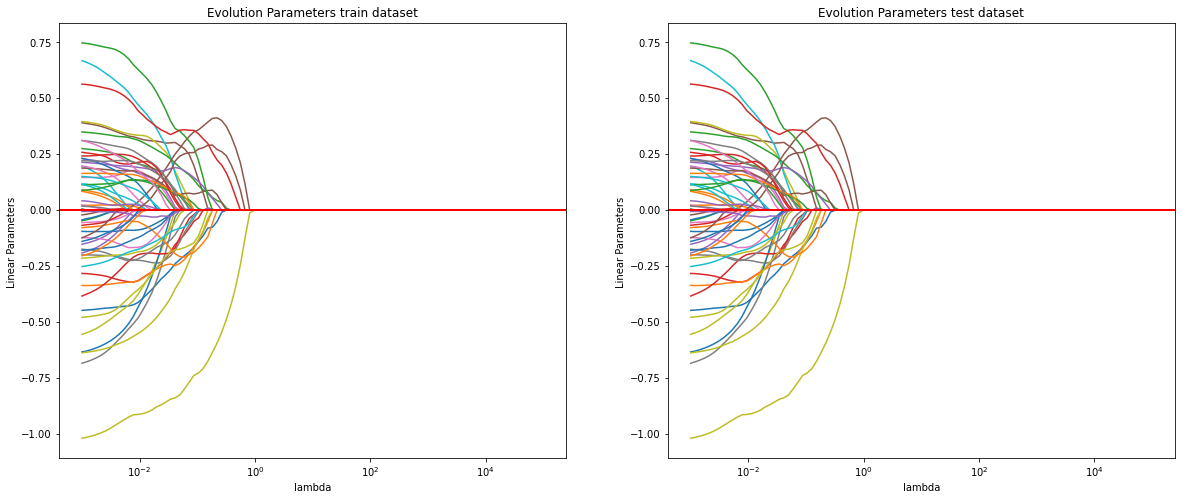

In [74]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plot_evolution_parameters_lambda_lasso(Xall_train,Yall_train,Xall_train,Yall_train,'train dataset')

plt.subplot(1,2,2)
plot_evolution_parameters_lambda_lasso(Xall_train,Yall_train,Xall_test,Yall_test,'test dataset')

plt.show()

Unlike the Ridge Regression, the weights can be equal to 0 for Lasso. Very quickly , all the coefficients are equal to 0. We can see the fact that with $\lambda =1$, all the weights are equal to 0, which what was observed before. With $\lambda = 1$ , $\hat{Y} = b$.
We have to choose a correct $\lambda$ to use Lasso Regression and see its real impact on the performance.

As Lasso, let's choose $\lambda^*$ that minimizes the MSE for the test dataset.

In [75]:
def plot_evolution_mse_lambda_lasso(X_train,Y_train,X_test,Y_test):
    #x = np.linspace(1e-3,1e5,num=100)
    x = np.logspace(-3,5,100)
    MSE_test = []
    MSE_train = []
    for alpha in x :
        lasso = Lasso(alpha = alpha)
        lasso.fit(X_train,Y_train)
        hat_Y_test = lasso.predict(X_test)
        hat_Y_train = lasso.predict(X_train)
        
        mse_test = round(mean_squared_error(Y_test,hat_Y_test),2)
        mse_train = round(mean_squared_error(Y_train,hat_Y_train),2)
        MSE_test.append(mse_test)
        MSE_train.append(mse_train)
     
    
    
    
    plt.plot(x,MSE_train,label="Train")
    plt.plot(x,MSE_test,label="Test")
    plt.title("Evolution of MSE under lambda (Lasso)")
    plt.xlabel("label")
    plt.ylabel("MSE")
    plt.xscale("log")
    plt.legend()

    plt.show() 

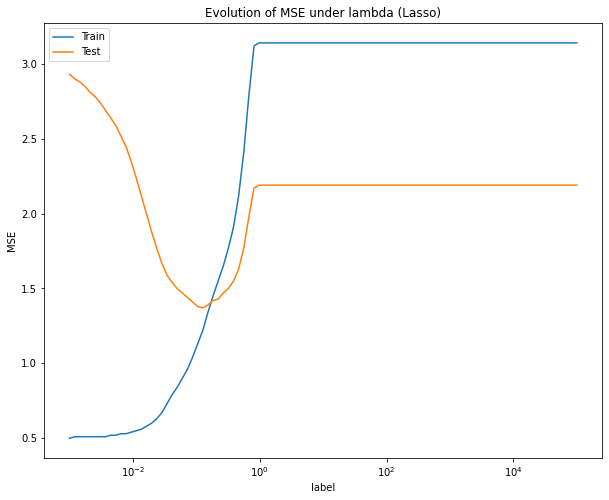

In [76]:
plt.figure(figsize=(10,8))
plot_evolution_mse_lambda_lasso(Xall_train,Yall_train,Xall_test,Yall_test)

We see clearly a minimum around $10^{-2}$ for the MSE on the test dataset.

In [77]:
def lambda_opti_lasso(X_train,Y_train,X_test,Y_test):
    x = np.logspace(-3,5,100)
    MSE = []
    for alpha in x :
        lasso = Lasso(alpha = alpha)
        lasso.fit(X_train,Y_train)
        hat_Y = lasso.predict(X_test)
        
        mse = round(mean_squared_error(Y_test,hat_Y),2)
        MSE.append(mse)
    ind = np.argmin(MSE)
    return x[ind]

In [78]:
best_lambda_lasso = lambda_opti_lasso(Xall_train,Yall_train,Xall_test,Yall_test)
print(f"The best lambda for Lasso Regression is equal to : {best_lambda_lasso}")

The best lambda for Lasso Regression is equal to : 0.1261856883066021


This $\lambda$ is far from 1 , so all the weights should not be equal to 0.
<br/>
Let's see all the weights with $\lambda = \lambda^*$

In [79]:
def coeff_optimated_model_lasso(X_train,Y_train,alpha):
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train,Y_train)
    return lasso.coef_ 

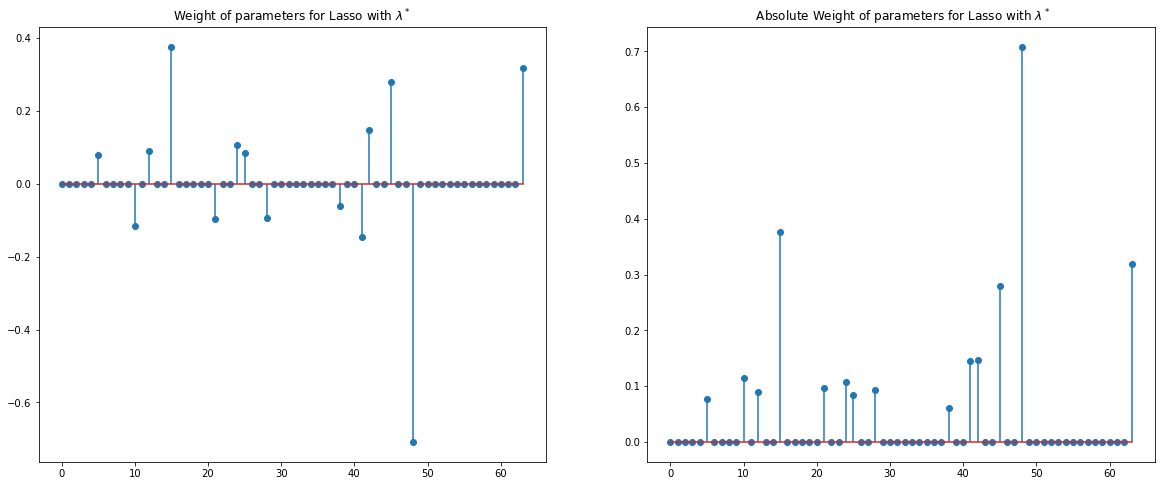

In [80]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.stem([i for i in range(64)],coeff_optimated_model_lasso(Xall_train,Yall_train,best_lambda_lasso).T,use_line_collection=True)
plt.title("Weight of parameters for Lasso with $\lambda^*$")

plt.subplot(1,2,2)
plt.stem([i for i in range(64)],np.abs(coeff_optimated_model_lasso(Xall_train,Yall_train,best_lambda_lasso)).T,use_line_collection=True)
plt.title(" Absolute Weight of parameters for Lasso with $\lambda^*$")


plt.show()

In [81]:
features_selected = coeff_optimated_model_lasso(Xall_train,Yall_train,best_lambda_lasso).T

In [82]:
print(f"The number of features selected by Lasso is {len(features_selected[features_selected != 0])}")

The number of features selected by Lasso is 14


14 features are selected by Lasso (their weights are not equal to 0). At the beginning, we had 64 features. So, the model keeps about 22% of the electrodes. It shows that the electrodes with a weight of zero are not useful to predict Y. As electrodes are implanted directly in the brain, it is useful for the surgeon to know that he can reduce the number of instruments (it is also a good news for the patient by the way).
<br/>
It seems that electrodes 42 and 45 are very important in the model because their weights are high in absolute value. It joins the remark in the first part, those electrodes can help to predict well Y.

# 4.2.2 Lasso with the best $\lambda$<a class="anchor" id="section_4_2_2"></a>

In [83]:
def optimated_model_lasso(X_train,Y_train,X_test,alpha):
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train,Y_train)
    hat_Y = lasso.predict(X_test)
    return hat_Y

In [84]:
hat_Y_train_lasso = optimated_model_lasso(Xall_train, Yall_train, Xall_train, best_lambda_lasso)
hat_Y_test_lasso = optimated_model_lasso(Xall_train, Yall_train, Xall_test, best_lambda_lasso)

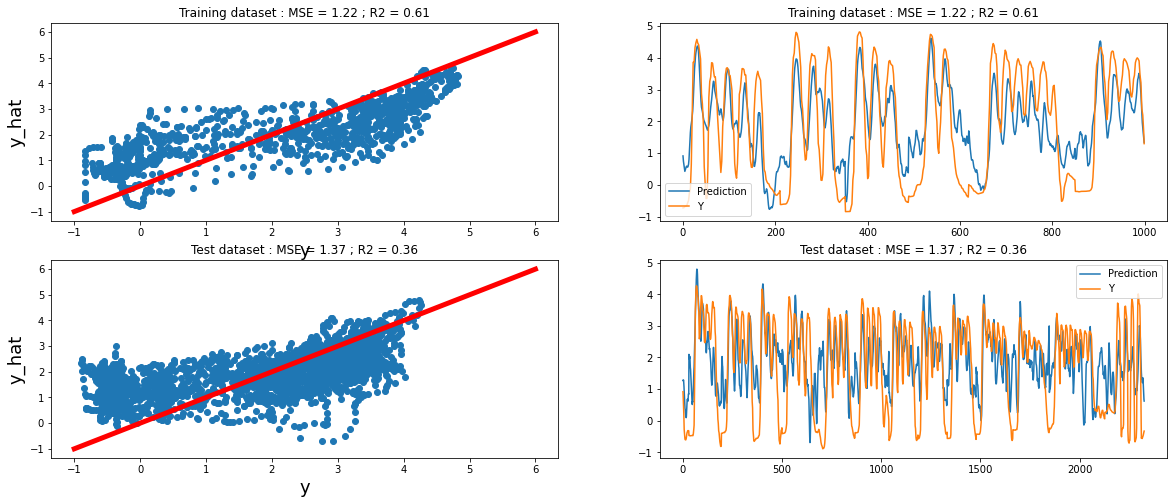

In [85]:
plot_predictions_bis(Yall_train, Yall_test, hat_Y_test_lasso, hat_Y_train_lasso)

Here also, the model has more tendency to underestimated the target variable , but we remark in the left graph that the values are very close to the first bissectrice, so the predictions are close to the real values.

The performances are better on the test dataset than the Lasso and the LS models.

# 5. Review on the linear regression<a class="anchor" id="chapter5"></a>

Here are the performances on the test dataset for linear regression :

| Metrics | Linear Regression         | Ridge Regresseion | Lasso Regression |
| :--------------- |:---------------:| ------------------:|:----------------:|
| MSE | 3.05 | 1.62 | 1.37 |
|R2 | -0.43 | 0.24 | 0.36 |

It seems that Lasso Regression is better than the others linear models and with less features. And this model is more interpretable than the others because of the weights egal to 0 and by the fact that the model highlists 2  important features. And Lasso only keeps 22% of features which is remarkable.
<br/> The penalization on parameters lead to better results because they favorize the impact on the prediciton of the features that are very useful. The LS is the worst because its R2 coefficient is negative.

# 6. Nonlinear Regression<a class="anchor" id="chapter6"></a>

# 6.1 Random Forest<a class="anchor" id="section_6_1"></a>

# 6.1.1 Random Forest with default parameters<a class="anchor" id="section_6_1_1"></a>

The deault parameters of Random Forest are :
- n_estimators = 100
- max_depth = NONE (nodes are expanded until all leaves are pure)
    

In [86]:
random_forest = RandomForestRegressor()
random_forest.fit(Xall_train, np.ravel(Yall_train))
hat_y_train_rf_default = random_forest.predict(Xall_train)
hat_y_test_rf_default = random_forest.predict(Xall_test)

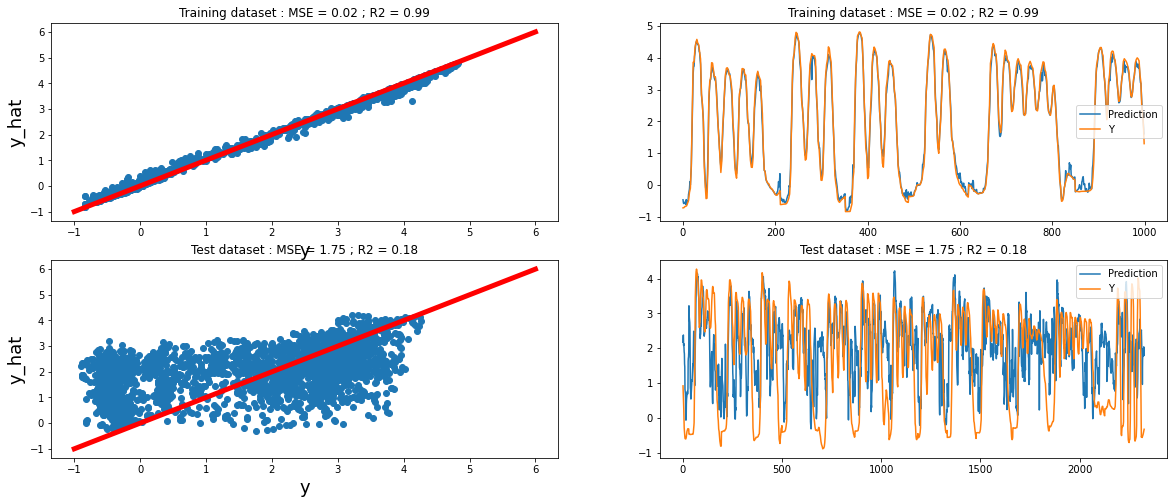

In [87]:
plot_predictions_bis(Yall_train, Yall_test, hat_y_test_rf_default, hat_y_train_rf_default)

Random Forest Regressor is better than LS model. Unlike the previous models, Random Forest underestimated most of the time Y. Let's find the best parameters to improve this result. 

# 6.1.2 Best Parameters<a class="anchor" id="section_6_1_2"></a>

To evaluate the performance of the random forest on the test dataset, I will change 2 parameters:
- n_estimators (number of trees in the model) 
- max_depth (The maximum depth of the tree) 

Let's start with n_estimators

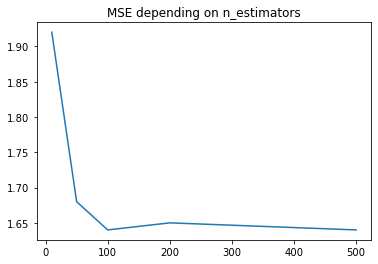

In [88]:
MSE_1 = []
n_estimators_list = [10,50,100,200,500]
for n_estimators in n_estimators_list :
    random_forest = RandomForestRegressor(n_estimators = n_estimators , random_state = 0)
    random_forest.fit(Xall_train, np.ravel(Yall_train))
    hat_y = random_forest.predict(Xall_test)
    mse_1 = round(mean_squared_error(Yall_test,hat_y),2)
    MSE_1.append(mse_1)
    

plt.plot(n_estimators_list,MSE_1)
plt.title("MSE depending on n_estimators")
plt.show()

The performance is better when n_estimators (number of trees in the model) is large. 
<br/> So now, let's evaluate the influence of max_depth with n_estimators = 500

MSE_2 : [1.68, 1.64, 1.64, 1.64, 1.64, 1.64]


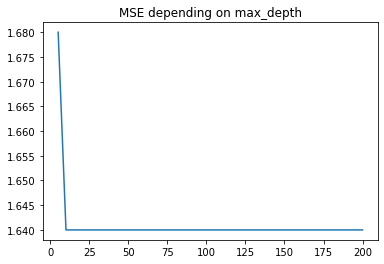

In [89]:
MSE_2 = []
max_depth_list = [5,10,20,50,100,200]
for max_depth in max_depth_list : 
    random_forest = RandomForestRegressor(n_estimators = 500 , max_depth = max_depth , random_state = 0)
    random_forest.fit(Xall_train, np.ravel(Yall_train))
    hat_y = random_forest.predict(Xall_test)
    mse_2 = round(mean_squared_error(Yall_test,hat_y),2)
    MSE_2.append(mse_2)
        

plt.plot(max_depth_list,MSE_2)
plt.title("MSE depending on max_depth")
print(f'MSE_2 : {MSE_2}')
plt.show()

It seems that from a certain value of max_depth (=10) , the MSE remains constant.

Finally, the best paramters for Random Forest are : 
- n_estimators = 500
- max_depth = 10

# 6.1.3 Random Forest with the best parameters<a class="anchor" id="section_6_1_3"></a>

In [107]:
random_forest_best = RandomForestRegressor(n_estimators = 500 , max_depth = 10 , random_state = 0)
random_forest_best.fit(Xall_train, np.ravel(Yall_train))
hat_y_train_rf_best = random_forest_best.predict(Xall_train)
hat_y_test_rf_best = random_forest_best.predict(Xall_test)

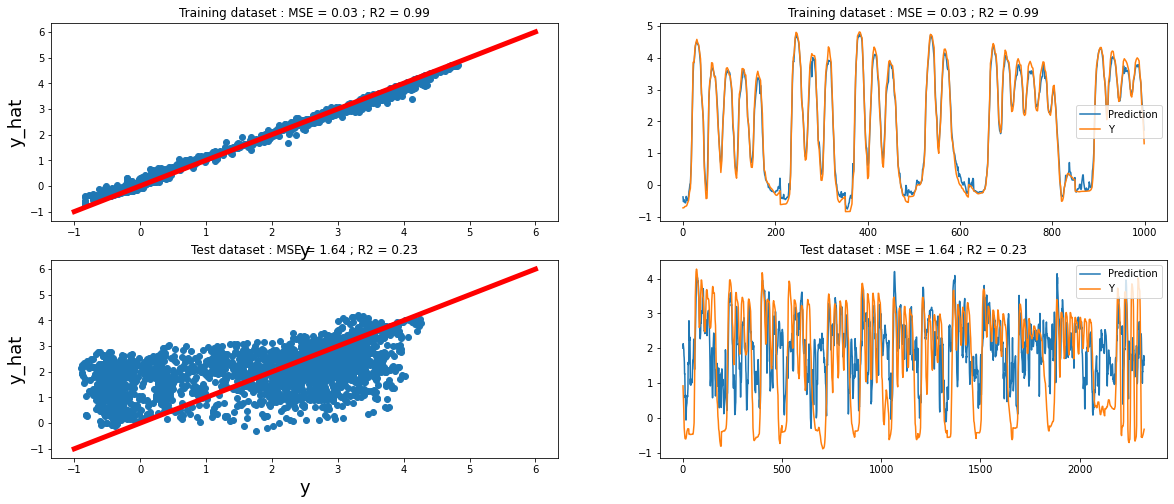

In [108]:
plot_predictions_bis(Yall_train, Yall_test, hat_y_test_rf_best, hat_y_train_rf_best)

So this Random Forest with those parameters is a bit better than the one with default parameters. The reason why , it is that the predictions of Random Forest is based on the results of multiple decision trees (here about 500). It summarizes all the result of all those trees , so it is not surprising that it gives good result. But, one default is that Random Forest is not an interpretable model especially for this dataset because we can not see the impact of electrodes on Y.


# 6.2 Support Vector Regression (SVR)<a class="anchor" id="section_5_2"></a>

The default parameters of SVR are :
- kernel = rbf
- gamma = scale
- C = 1.0

# 6.2.1 SVR with default parameters<a class="anchor" id="section_6_2_1"></a>

In [92]:
svr = SVR().fit(Xall_train, np.ravel(Yall_train))

hat_y_train_svr_default = svr.predict(Xall_train)
hat_y_test_svr_default = svr.predict(Xall_test)


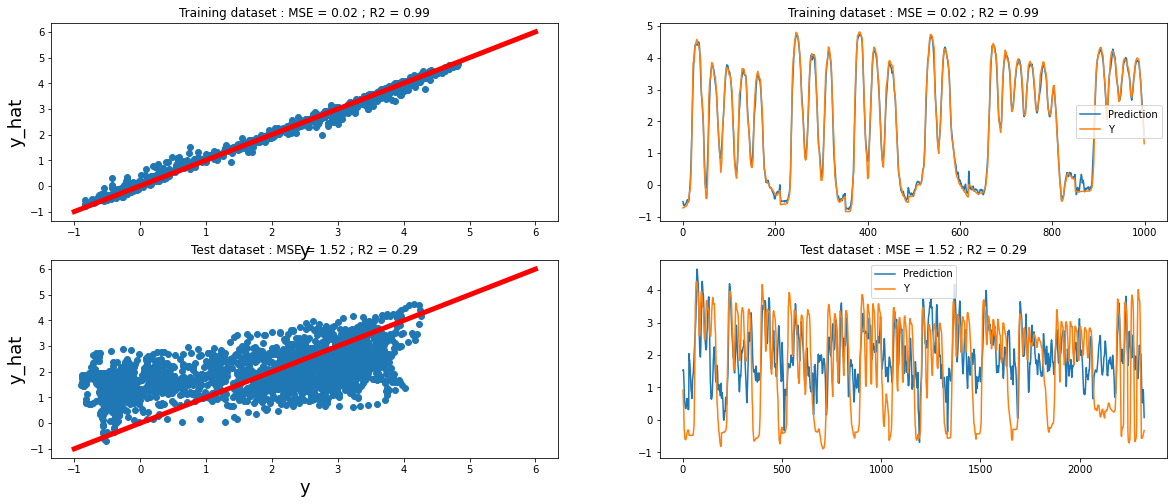

In [93]:
plot_predictions_bis(Yall_train, Yall_test, hat_y_test_svr_default, hat_y_train_svr_default)

SVR is better than Random Forest, but let's fit the parameters to hope to improve the model.

# 6.2.2 Best parameters<a class="anchor" id="section_6_2_2"></a>

To evaluate the performance of the Support Vector Regression (SVR) on the test dataset, I will change several parameters:
- the kernel used to project our data in a space larger than the data space
- degree if the best kernel is polynomial 
- C, a regularization parameter (l2 penality)

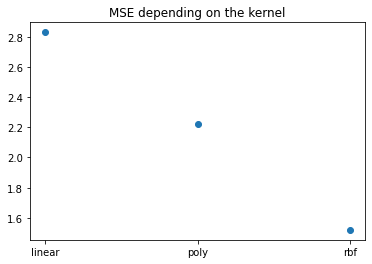

In [94]:
kernel_list = ['linear','poly','rbf']
MSE_kernel = []
for kernel in kernel_list :
    svr = SVR(kernel = kernel)
    svr.fit(Xall_train, np.ravel(Yall_train))
    hat_y = svr.predict(Xall_test)
    mse_kernel = round(mean_squared_error(Yall_test,hat_y),2)
    MSE_kernel.append(mse_kernel)
plt.scatter(kernel_list,MSE_kernel)
plt.title("MSE depending on the kernel")
plt.show()




So the rbf kernel ($k(u,v) = exp(-\gamma ||u-v||^2)$) seems to be the best.

best gamma : 0.016297508346206444


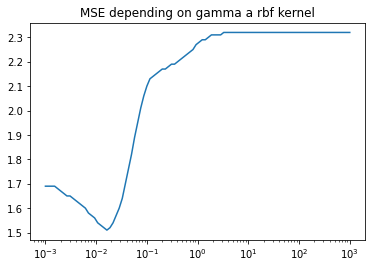

In [95]:
G_list = list(np.logspace(-3,3,100))


MSE_G = []
for gamma in G_list :
   
    svr = SVR(kernel='rbf',gamma = gamma )
    svr.fit(Xall_train, np.ravel(Yall_train))
    hat_y = svr.predict(Xall_test)
    mse_G = round(mean_squared_error(Yall_test,hat_y),2)
    MSE_G.append(mse_G)

plt.plot(G_list,MSE_G)
plt.title("MSE depending on gamma a rbf kernel")
plt.xscale("log")
best_gamma = G_list[np.argmin(MSE_G)]
print(f"best gamma : {best_gamma}")

plt.show()
    
    

So the best gamma is 0.02

The best C : 0.5590810182512228


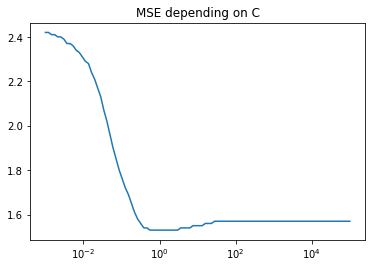

In [109]:
C_list = np.logspace(-3,5,100)
MSE_C = []
for C in C_list : 
    svr = SVR(kernel='rbf' , gamma = 0.02 , C = C)
    svr.fit(Xall_train, np.ravel(Yall_train))
    hat_y = svr.predict(Xall_test)
    mse_C = round(mean_squared_error(Yall_test,hat_y),2)
    MSE_C.append(mse_C)
plt.plot(C_list,MSE_C)
plt.title("MSE depending on C")
plt.xscale("log")
best_C = C_list[np.argmin(MSE_C)]
print(f"The best C : {best_C}")

plt.show()

Finally, the best parameters for the SVR are :
- kernel : rbf
- gamma : 0.02
- C : 0.6

# 6.2.3 SVR with the best parameters<a class="anchor" id="section_6_2_3"></a>

In [110]:
svr_best = SVR(kernel = 'rbf' , gamma = 0.02 , C =0.6)
svr_best.fit(Xall_train, np.ravel(Yall_train))
hat_y_train_svr_best = svr_best.predict(Xall_train)
hat_y_test_svr_best = svr_best.predict(Xall_test)

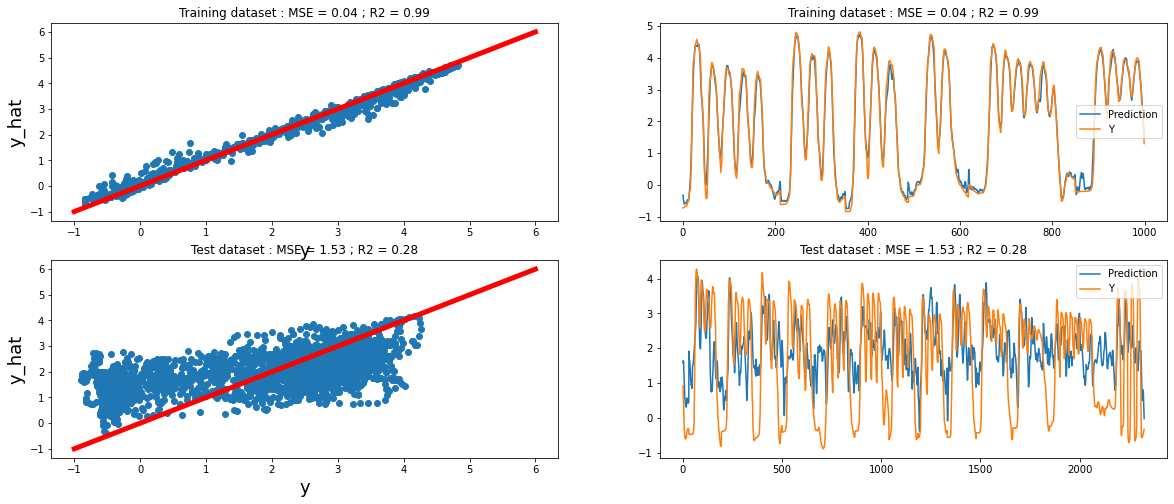

In [111]:
plot_predictions_bis(Yall_train, Yall_test, hat_y_test_svr_best, hat_y_train_svr_best)

The MSE on the tes dataset is very close to the one with default parameters. Which means, that the best parameters are close to the default parameters. 
<br/> In fact, the default parameters are :
- kernel : rbf
- gamma = $\frac{1}{\text{number of features}\times Var(X)}$
- C = 1.0

In [112]:
default_gamma = 1/(Xall_train.shape[1]*np.var(Xall_train))
print(f"default gamma = {default_gamma}")

default gamma = 0.015433056807728532


So the best paramters are very close to the default parameters, which explains the similarity between the MSEs

So this model is better than Random Forest but not as good than Lasso. . One reason that is is better than Random Forest can be with the kernel , the data are projected in a space with a gaussian kernel. In this space, it seems it is better to do a regression which leads to better result. And also, the regularization can reinforce this performance, because we saw earlier that regularization leads to better result.
<br/> Here also, the model underestimates Y

# 6.3 Multi Layer Perceptrons (MLP)<a class="anchor" id="section_6_3"></a>

The default parameter of MLP is :
 - hidden_layer_size = (100,)

# 6.3.1 MLP with default parameters

In [100]:
mlp = MLPRegressor(random_state = 0 , shuffle=False)
mlp.fit(Xall_train, np.ravel(Yall_train))
hat_y_train_mlp_default = mlp.predict(Xall_train)
hat_y_test_mlp_default = mlp.predict(Xall_test)

In [101]:
mlp.n_layers_

3

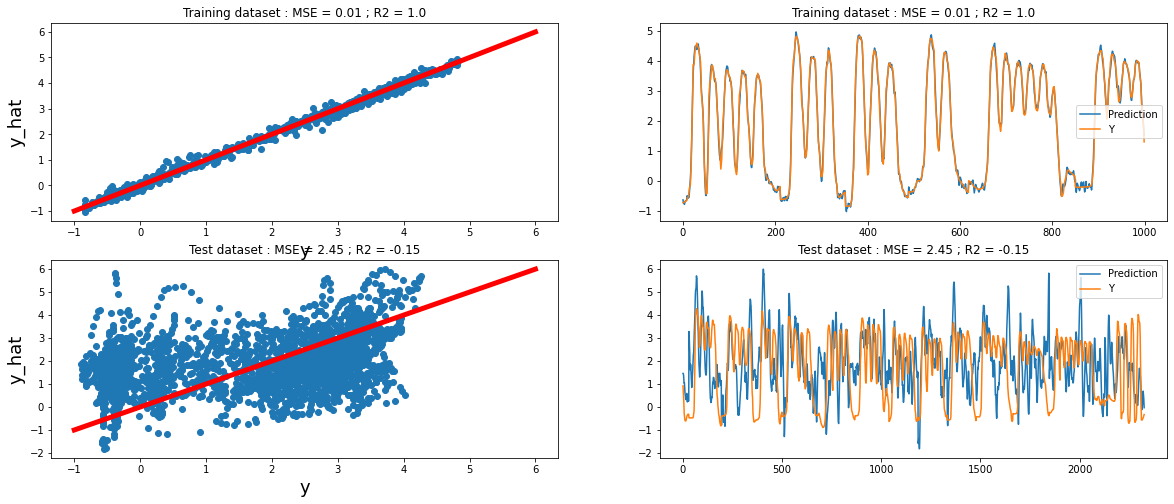

In [102]:
plot_predictions_bis(Yall_train, Yall_test, hat_y_test_mlp_default, hat_y_train_mlp_default)

With default parameters, MLP is not better than the two previous non linear regressions and the penalized regression. Its performance is similar than LS with its R2 coefficient negative and its MSE far from 0. Let's see if we can improve this performance by changing the parameter.

# 6.3.2 Best parameters<a class="anchor" id="section_6_3_2"></a>

In this model I will change one  parameter :
- hidden_layer_sizes


I will not change the activation function because by default it is 'Relu' and this activation function on hidden layers is known to reduce the impact of vanishing gradient during the backpropagation.

Best hidden layer size : (500,)


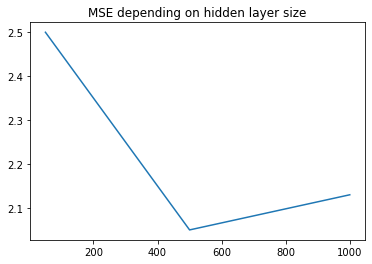

In [113]:
hidden_layer_sizes_list = [(50,),(100,),(500,),(1000,)]
MSE_hls = []
for hidden_layer_sizes in hidden_layer_sizes_list :
    mlp = MLPRegressor(random_state = 0 , shuffle=False , hidden_layer_sizes = hidden_layer_sizes)
    mlp.fit(Xall_train, np.ravel(Yall_train))
    hat_y = mlp.predict(Xall_test)
    mse_hls = round(mean_squared_error(Yall_test,hat_y),2)
    MSE_hls.append(mse_hls)
plt.plot(hidden_layer_sizes_list,MSE_hls)
plt.title("MSE depending on hidden layer size")
best_hidden_size = hidden_layer_sizes_list[np.argmin(MSE_hls)]
print(f"Best hidden layer size : {best_hidden_size}")
plt.show()
    
    
    

# 6.3.3 MLP with the best parameters<a class="anchor" id="section_6_3_3"></a>

In [104]:
mlp_best = MLPRegressor(random_state = 0 , shuffle=False , hidden_layer_sizes = (500,) )
mlp_best.fit(Xall_train, np.ravel(Yall_train))
hat_y_train_mlp_best = mlp_best.predict(Xall_train)
hat_y_test_mlp_best = mlp_best.predict(Xall_test)

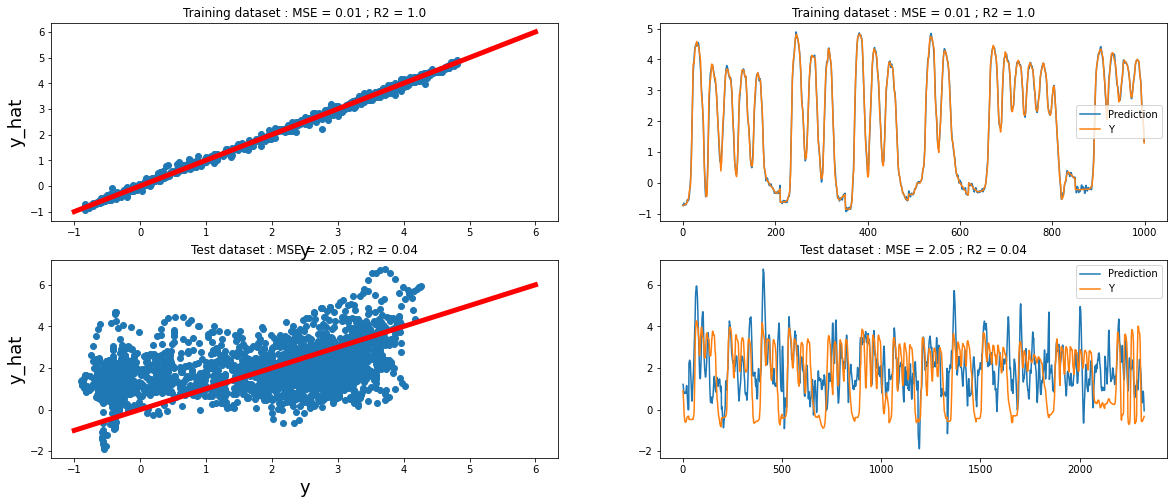

In [105]:
plot_predictions_bis(Yall_train, Yall_test, hat_y_test_mlp_best, hat_y_train_mlp_best)

We have better results but not better than Random Forest or SVR. It is still worse than penalized linear regressions And as many Deep Learning, the interpretation of what is done is not clear. Maybe this model calculated too many times weights that are not efficient at all.
<br/> But here, the model has a tendency to overestimate Y.

# 7. Final comparison of the performances<a class="anchor" id="chapter7"></a>

In [114]:
perf = {}
perf['MSE on Test'] = [3.05,1.62,1.37,1.64,1.53,2.05]
perf['R2 on Test'] = [-0.43,0.24,0.36,0.23,0.28,0.04]
models = ['LS','Ridge','Lasso','Random Forest','SVR','MLP']
perf_dataframe = pd.DataFrame(perf,index = models)
print(perf_dataframe.sort_values("MSE on Test"))

               MSE on Test  R2 on Test
Lasso                 1.37        0.36
SVR                   1.53        0.28
Ridge                 1.62        0.24
Random Forest         1.64        0.23
MLP                   2.05        0.04
LS                    3.05       -0.43


 1) Above are all the models with their performances on the test Dataset. It seems that Lasso gives the best results. I remark that models that give better result (Lasso, Ridge) have a tendency to underestimate the flexion.

2) The most interpretable models are linear models because the model is a linear combinaison between the features. So, with the coefficient, we can see the most important features in the model (with regularized methods). MLP can not be interpretable because with the number of hidden layers, it becomes difficult to understand what happens. With SVR, we use the kernel trick with a rbf kernel , so the features are transformed. And finally, with a Random Forest, it becomes also difficult to understand what happens, because we apply bagging on decision trees. A decision tree can be interpretable but numerous decision trees are harder to interpret. And Finally, Lasso uses only 22% of initial features , so we reduce the dimension of the variables and it can lead to reduce overfitting.

3) I think that regularized linear models are the best in medical perspective because as I said before they can help to understand a domain by penalized features. Here, we have data relative to signals received by electrodes. They are implanted directly in the brain of the patient and therefore, the electrodes are connected to differents parts of the brain. For example, with the Lasso model, we saw that some weights are equal to 0 which means that those features are not useful to predict the flexion. In other words, some parts of the brain are not useful to predict this flexion. So, it can be useful for doctors or scientists in general to know that, it can help them to understand the phenomenon , to precisely locate the areas responsible for the movements.  

4) Non linearity models do not give the best results. So they are not necessary for that dataset and they are not interpretable which is not the case for linear models.

5) Doing the validation on the test data  is not a good practise, because one important thing in Machine Learning to evaluate the capacity of a model to generalize is that this model should never "see" the test data. Here, during this lab, we fitted the parameters depending on the MSE of the test dataset. So, the generalization is a bit biased because the model learns also from the test dataset. To provide a model to a client for prediction, I may include a validation dataset which is part of the "learning dataset" (train + valisation dataset). The idea is to fit the model on the train dataset and then fit the parameters depending on the result of the MSE on the validation dataset. Finally, we can evaluate really the performance on the test dataset with the best parameters and the model does not see the test dataset.

# Discussion about the Practical Section

This lab was very interesting because we compare the performance of models in a same dataset. What was also interersting was the fact that we change the parameters to see the effect on the performance. It helps me to understand well the impact of those parameters in a model. Using Random Forest as a Regressor was new, I did not expect until the course that we can use this method for regression problem. At the beginning, I had some difficulties to understand the dataset. I did not get that each of column of the matrix Xall represents a a time signal for an electrode. Indeed, it is important to take time to understand the dataste because its comprehension will influence the quality of the interpretation which is essential in Machine Learning.